In [1]:
# References:
# - https://www.jeremyjordan.me/semantic-segmentation/#loss
# - Writeup of the #1 solution and the case study (linked from the above)

In [1]:
# Structure:
# - Use data from the data science bowl
# - Build things up slowly
# - Data exploration
#   - Where did this data come from?
#   - What kind of cells are these? Why is it important to detect nuclei?
#   - Why are some in color and some not in color?
#   - How many are in color, how many aren't?
#   - What are the different sizes 
# - Problem formulation and metric design
#   - Is this the instance version or not?
#   - What metrics make sense?
#   - Code for a model interface, quantitative evaluation, and error analysis
# - Baselines
#   - Random output
#   - Classical computer vision techniques
#   - Shallow convolutional networks
# - Simple techniques for improving on the baseline  
#   - Data augmentation
#   - Post processing
# - Improving on the baseline through better network architectures
#   - Simple UNet
#   - Best practice UNet
#   - 

from collections import defaultdict
import os
from pathlib import Path
import pickle
import random
import sys
import warnings

import imagecodecs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from skimage.color import rgb2gray, gray2rgb
from skimage.io import imread, imsave, imshow
from skimage.measure import find_contours
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import wandb

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')

CN_PATH = 'data/cell-nuclei-kaggle/stage1/train/'
CACHE_PATH = 'data/cache'

# Create CACHE_PATH if it doesn't already exist
Path(CACHE_PATH).mkdir(parents=True, exist_ok=True)

# Simple wrapper for tqdm to give a good default width.
def stqdm(iterator, **kwargs):
    return tqdm(iterator, bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}', **kwargs)

_ = wandb.login()

wandb: Currently logged in as: benbirnbaum (use `wandb login --relogin` to force relogin)


In [3]:
# Where did this data come from?

# https://bbbc.broadinstitute.org/BBBC038
# Full paper describing motivation and results: https://personal.broadinstitute.org/anne/publications/127_Caicedo_NatMethods_2019.pdf

# Motivation comes from this video: https://datasciencebowl.com/2018dsbtutorial/
# High level idea: identifying cells automatically is a key step toward high-throughput testing of compounds.
# We already have robots that can add automate the mechanical aspects of the experiments, but we need
# computer vision solutions to automate the analysis part of the experiment.

# Why find a nucleus instead of the whole cell? It's the most easily distinguished part of the cell,
# especially if the cell is given a dye that lights up DNA. Once the nucleus is identified,
# then the rest of the cell can be analyzed more easily.

# There are already algorithms used in practice to detect nuclei, but they tend to be classical computer vision
# algorithms. But these
# - don't perform well in messy images, e.g. where nuclei overlap or an entire tissue sample is present
# - need to be tuned to specific equipment and stains

# Key goal is robustness

In [4]:
# Let's explore our first data set. This is coming from the 2018 Data Science Bowl.
# To keep things simple, we'll focus only on the training set (and split out some
# of the training data for validation). This omits the key motivation for the
# Data Science Bowl challenge, which was to develop a single classifier that generalizes
# well to new distributions of data, based on changes in experimental setup, cell type, etc.
# But for our purposes of gaining intuition around various segmentation algorithms,
# it will suffice.

Num cell nuclei examples: 670


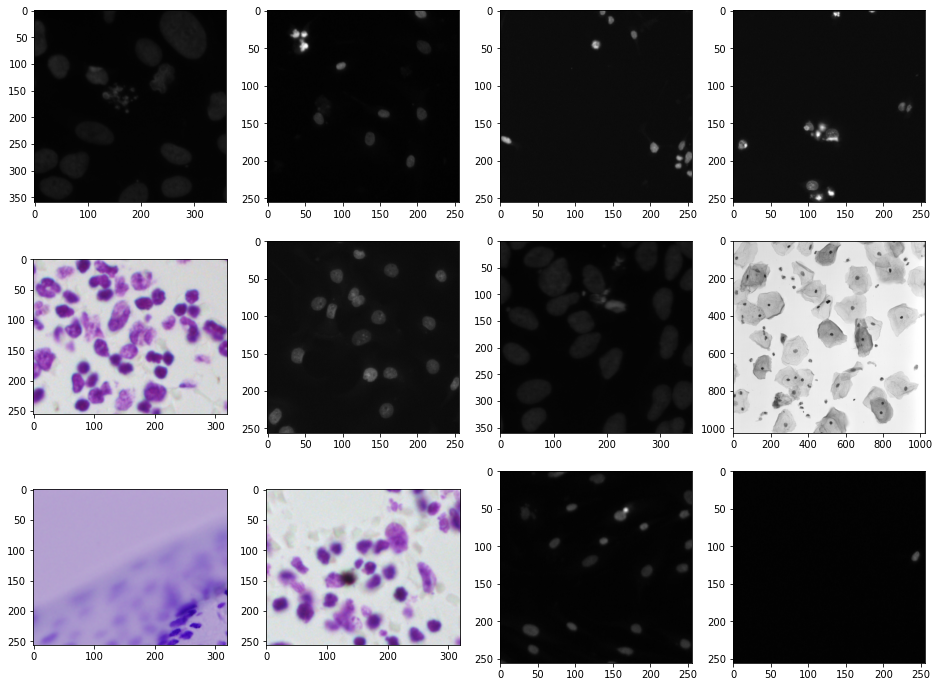

In [2]:
# First, let's take a look at a random sample of the cell nuclei images to get a sense for what we're working with.

cn_ids = next(os.walk(CN_PATH))[1]
print('Num cell nuclei examples: {}'.format(len(cn_ids)))

random.seed(906)
rand_ids = random.sample(cn_ids, 12)
_, subaxes = plt.subplots(3, 4, figsize=(16, 12))
subaxes = subaxes.flatten()
for i, id_ in enumerate(rand_ids):
    img = imread(CN_PATH + id_ + '/images/' + id_ + '.png')
    subaxes[i].imshow(img)

Immediately, we observe that this data is fairly messy:
- The images come in different sizes
- Some are color images and some are grayscale
- There are various levels of focus of the cell nuclei
- It appears that different microscopes, staining techniques, and even cell types were used.

The messiness of this data is by design. It's representative of the type of heterogeneity
drug development researchers observe regularly, and the organizers of the competition wanted
to see whether a single algorithm could be developed that generalized across images like this.

The labels for these images consist of one image mask per nucleus.
The objective of the competition was to separately identify each nucleus
rather than a single mask for the image that indicated whether a
nucleus was present or not. Thus, it was an "instance segmentation" task
rather than a "segmentation" task. This was because (1) the segmentation
problem (i.e. just distinguishing foreground from background) is relatively easy
and (2) downstream applications (such as cell counting) needed to have each
nucleus separately identified.

But for our purposes, we'll start with the simpler segmentation task. That
means we'll need to merge the individual nucleus-level masks into a single
mask for the image.

We're now ready to load the images and masks from disk into memory. The process
of combining masks and resizing images to a uniform size is somewhat slow,
so we'll load from a cache if possible. To simplify things, we'll
convert all images to grayscale.

In [3]:
IMG_HEIGHT = 128
IMG_WIDTH = 128

def load_from_cache_if_exists(cache_path, obj):
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as fp:
            obj = pickle.load(fp)
    return obj

cn_images_cache_path = os.path.join(CACHE_PATH, 'cn_images.pickle')
cn_images = load_from_cache_if_exists(cn_images_cache_path, [])


if len(cn_images) == 0:
    for id_ in stqdm(cn_ids):
        img = imread(os.path.join(CN_PATH, id_, 'images', id_ + '.png'))
        
        # Some of the images are rgba. We just discard the last dimension.
        img = img[:, :, :3]

        # Convert to grayscale and scale down a uniform size of 128x128
        img = rgb2gray(img)
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

        cn_images.append(img)
    
    with open(cn_images_cache_path, 'wb') as fp:
        pickle.dump(cn_images, fp)


cn_masks_cache_path = os.path.join(CACHE_PATH, 'cn_masks.pickle')
cn_masks = load_from_cache_if_exists(cn_masks_cache_path, [])

if len(cn_masks) == 0:
    for id_ in stqdm(cn_ids):
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH))
        masks_dir = os.path.join(CN_PATH, id_, 'masks')
        for mask_file in next(os.walk(masks_dir))[2]:
            mask_ = imread(os.path.join(masks_dir, mask_file))
            mask_ = resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
            mask = np.maximum(mask, mask_)
        mask = (mask > 0).astype('float64')
        
        cn_masks.append(mask)
        
    with open(cn_masks_cache_path, 'wb') as fp:
        pickle.dump(cn_masks, fp)

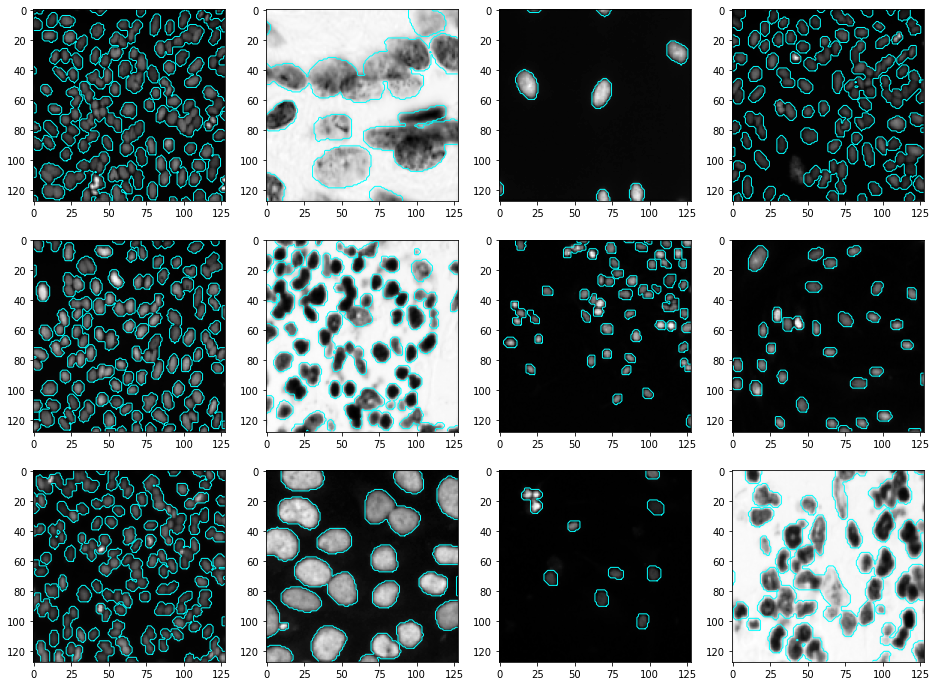

In [17]:
# Let's look some random images after they've been processed.
# We'll look at 12 images, and for each image we'll display its
# corresponding mask directly beneath it.
random.seed(36)

def show_overlayed_mask(mask, ax, color='cyan'):
    contours = find_contours(mask)
    for contour in contours:
        ax.plot(contour[:, 1], contour[:, 0], color=color, linewidth=1)

rand_ids = random.sample(range(len(cn_images)), 12)

_, subaxes = plt.subplots(3, 4, figsize=(16, 12))
subaxes = subaxes.flatten()
for i, img_idx in enumerate(rand_ids):
    subaxes[i].imshow(cn_images[img_idx], cmap='Greys_r')
    show_overlayed_mask(cn_masks[img_idx], subaxes[i])

In [5]:
X_cn = np.stack(cn_images).astype(np.float32)
Y_cn = np.stack(cn_masks).astype(np.float32)
X_cn_train, X_cn_val, Y_cn_train, Y_cn_val = train_test_split(X_cn, Y_cn, test_size=0.2, random_state=609)

In [6]:
def compute_metrics(Y_true, Y_pred):
    assert Y_true.shape == Y_pred.shape
    n = Y_true.shape[0]
    ious = []
    dices = []
    for i in range(n):
        intersection = np.logical_and(Y_true[i, :, :], Y_pred[i, :, :])
        union = np.logical_or(Y_true[i, :, :], Y_pred[i, :, :])
        ious.append(np.sum(intersection) / float(np.sum(union)))
        dices.append(2. * np.sum(intersection) / (np.sum(Y_true[i, :, :]) + np.sum(Y_pred[i, :, :])))
    return np.mean(ious), np.mean(dices), ious, dices

np.random.seed(821)

Y_cn_pred = np.ones(Y_cn_val.shape)
mean_iou, mean_dice, _, _ = compute_metrics(Y_cn_pred, Y_cn_val)

print('Model: predicting all 1s')
print('IoU:  {:.3f}'.format(mean_iou))
print('Dice: {:.3f}'.format(mean_dice))

Model: predicting all 1s
IoU:  0.193
Dice: 0.298


In [8]:
def iou(Y_true, Y_pred):
    # Define a torch version of iou so it can be logged by PyTorch Lightning
    i = torch.logical_and(Y_true, Y_pred)
    u = torch.logical_or(Y_true, Y_pred)
    i_sums = torch.sum(torch.sum(i, axis=2), axis=1)
    u_sums = torch.sum(torch.sum(u, axis=2), axis=1)
    return torch.mean(i_sums / u_sums)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels, max_pool=2):
        super(Down, self).__init__()
        self.max_pool = nn.MaxPool2d(max_pool)
        self.conv = nn.Conv2d(in_channels, out_channels, 3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.max_pool(x)
        x = self.conv(x)
        x = self.relu(x)
        return x


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, 3, stride=2, padding=1, output_padding=1)
        self.relu = nn.ReLU()
    
    def forward(self, x, c):
        x = self.deconv(x)
        x = self.relu(x)
        x = torch.cat([x, c], dim=1)
        return x

    
class UNet(pl.LightningModule):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.down1 = Down(1, 16, max_pool=1)
        self.down2 = Down(16, 32)
        self.down3 = Down(32, 64)
        self.down4 = Down(64, 128)
        self.down5 = Down(128, 256)
        self.up4 = Up(256, 128)
        self.up3 = Up(256, 64)
        self.up2 = Up(128, 32)
        self.up1 = Up(64, 16)
        self.final_conv = nn.Conv2d(33, 1, 1)

    def forward(self, x):
        if should_print:
            print(len(x))
        x = x.unsqueeze(1)
        c1 = self.down1(x)
        c2 = self.down2(c1)
        c3 = self.down3(c2)
        c4 = self.down4(c3)
        r = self.down5(c4)
        u4 = self.up4(r, c4)
        u3 = self.up3(u4, c3)
        u2 = self.up2(u3, c2)
        u1 = self.up1(u2, c1)
        out = torch.cat([x, u1], dim=1)
        out = self.final_conv(out)
        out = out.squeeze()
        return out

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer),
                'monitor': 'val/loss',
            }
        }
    
    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        y_pred = self.forward(x)
        y_pred_hat = y_pred.detach() > 0.5
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(torch.flatten(y_pred, 1), torch.flatten(y, 1))
        self.log('train/loss', loss)
        self.log('train/iou', iou(y, y_pred_hat))
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        y_pred = self.forward(x)
        y_pred_hat = y_pred.detach() > 0.5
        criterion = nn.BCEWithLogitsLoss()
        loss = criterion(torch.flatten(y_pred, 1), torch.flatten(y, 1))
        self.log('val/loss', loss)
        self.log('val/iou', iou(y, y_pred_hat))

    def predict_step(self, batch, batch_idx, dataloader_idx=None):
        return self(batch[0])

        
        
class CNDataModule(pl.LightningDataModule):
    def setup(self, stage=None):
        self.train_data = TensorDataset(torch.from_numpy(X_cn_train), torch.from_numpy(Y_cn_train))
        self.val_data = TensorDataset(torch.from_numpy(X_cn_val), torch.from_numpy(Y_cn_val))
        self.predict_data = TensorDataset(torch.from_numpy(X_cn_val))
    
    def train_dataloader(self):
        return DataLoader(self.train_data, batch_size=16)
    
    def val_dataloader(self):
        return DataLoader(self.val_data, batch_size=16)

    def predict_dataloader(self):
        return DataLoader(self.predict_data, batch_size=16)

wandb.init(project='test-segmentation')    

should_print = False
model = UNet()
data_module = CNDataModule()
trainer = pl.Trainer(
    deterministic=True,
    gpus=1,
    logger=pl.loggers.WandbLogger(),
    max_epochs=80,
)
trainer.fit(model, data_module)
Y_cn_pred = torch.sigmoid(torch.cat(trainer.predict(model, datamodule=data_module), axis=0)).cpu().numpy() > 0.5

mean_iou, mean_dice, _, _ = compute_metrics(Y_cn_pred, Y_cn_val)

print('Model: basic U-Net')
print('IoU:  {:.3f}'.format(mean_iou))
print('Dice: {:.3f}'.format(mean_dice))

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type   | Params
--------------------------------------
0 | down1      | Down   | 160   
1 | down2      | Down   | 4.6 K 
2 | down3      | Down   | 18.5 K
3 | down4      | Down   | 73.9 K
4 | down5      | Down   | 295 K 
5 | up4        | Up     | 295 K 
6 | up3        | Up     | 147 K 
7 | up2        | Up     | 36.9 K
8 | up1        | Up     | 9.2 K 
9 | final_conv | Conv2d | 34    
--------------------------------------
881 K     Trainable params
0         Non-trainable params
881 K     Total params
3.524     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/miniconda3/envs/unet/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:103: UserWarning: The dataloader, predict dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 4 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f'The dataloader, {name}, does not have many workers which may be a bottleneck.'


Predicting: 34it [00:00, ?it/s]

Model: basic U-Net
IoU:  0.824
Dice: 0.899


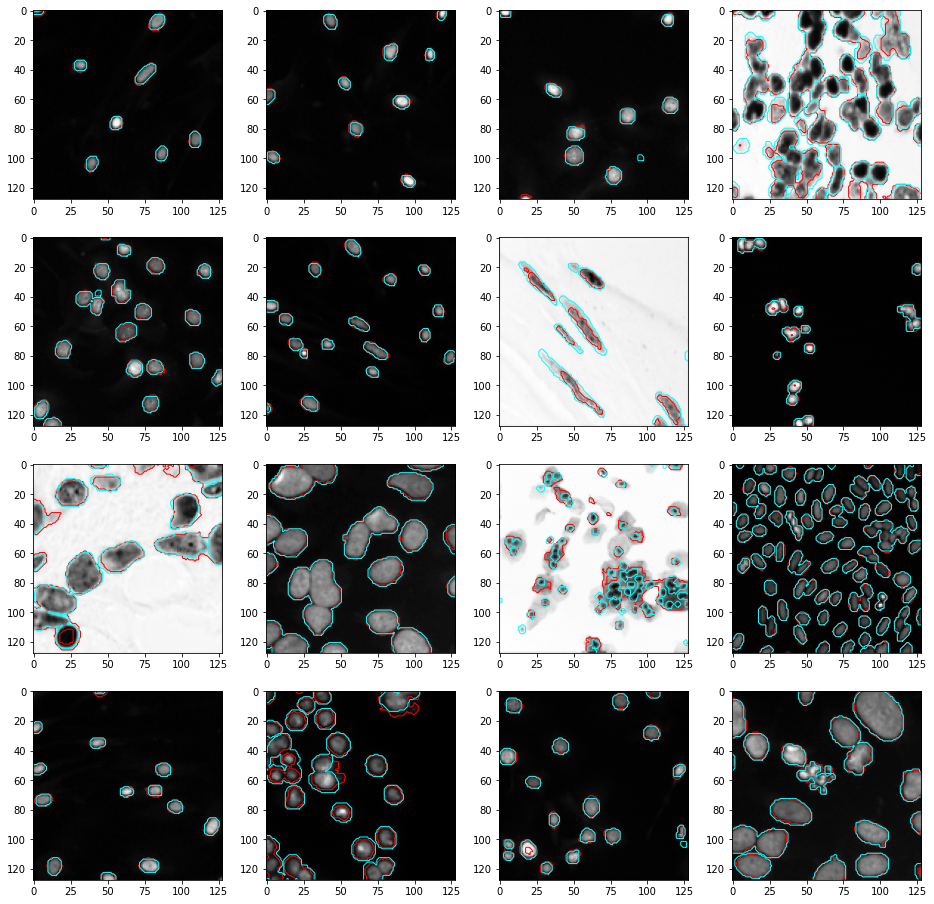

In [24]:
def plot_random_predicted_masks(images, true_masks, predicted_masks, num_images=16, random_seed=88):
    random.seed(888)
    rand_ids = random.sample(range(len(images)), num_images)
    rows = (num_images + 1) // 4
    _, subaxes = plt.subplots(rows, 4, figsize=(16, rows * 4))
    subaxes = subaxes.flatten()
    for i, img_idx in enumerate(rand_ids):
        img = images[img_idx, :, :]
        true_mask = true_masks[img_idx, :, :]
        predicted_mask = predicted_masks[img_idx, :, :]
        subaxes[i].imshow(img, cmap='Greys_r')
        show_overlayed_mask(predicted_mask, subaxes[i], color='red')
        show_overlayed_mask(true_mask, subaxes[i], color='cyan')

plot_random_predicted_masks(X_cn_val, Y_cn_val, Y_cn_pred)

In [7]:
# Nerve segmentation data
# https://www.kaggle.com/c/ultrasound-nerve-segmentation/data

NERVE_PATH = 'data/ultrasound-nerve-segmentation/'

train_mask_df = pd.read_csv(os.path.join(NERVE_PATH, 'train_masks.csv'))
train_mask_df.head()

,subject,img,pixels
0,1,1,168153 9 168570 15 168984 22 169401 26 169818 ...
1,1,2,96346 7 96762 16 97179 27 97595 35 98012 40 98...
2,1,3,121957 2 122365 26 122784 28 123202 31 123618 ...
3,1,4,110980 9 111393 21 111810 33 112228 43 112647 ...
4,1,5,NaN


In [25]:
nerve_img_info = defaultdict(dict)
for idx, row in train_mask_df.iterrows():
    nerve_img_info[row['subject']][row['img']] = not pd.isna(row['pixels'])
  
all_sub_img_pairs = [(sub_idx, img_idx) for sub_idx in nerve_img_info for img_idx in nerve_img_info[sub_idx]]

num_subjects = len(nerve_img_info)
num_images = len(all_sub_img_pairs)
num_images_with_nerve = len([
    (sub_idx, img_idx) for (sub_idx, img_idx) in all_sub_img_pairs if nerve_img_info[sub_idx][img_idx]])
    
print('Number of subjects: {}'.format(num_subjects))
print('Number of images: {}'.format(num_images))
print('Number of images with nerve: {}'.format(num_images_with_nerve))

Number of subjects: 47
Number of images: 5635
Number of images with nerve: 2323


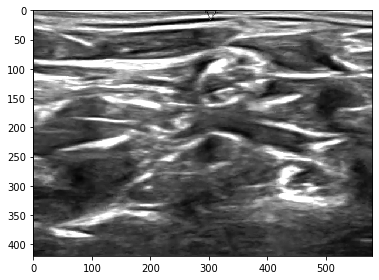

In [15]:
def load_image(sub_idx, img_idx):
    path = os.path.join(NERVE_PATH, 'train', '{}_{}.tif'.format(sub_idx, img_idx))
    return imread(path)

def load_mask(sub_idx, img_idx):
    path = os.path.join(NERVE_PATH, 'train', '{}_{}_mask.tif'.format(sub_idx, img_idx))
    return imread(path)

# Let's again load 12 random images and place their masks directly below them

imshow(load_image(1, 3))

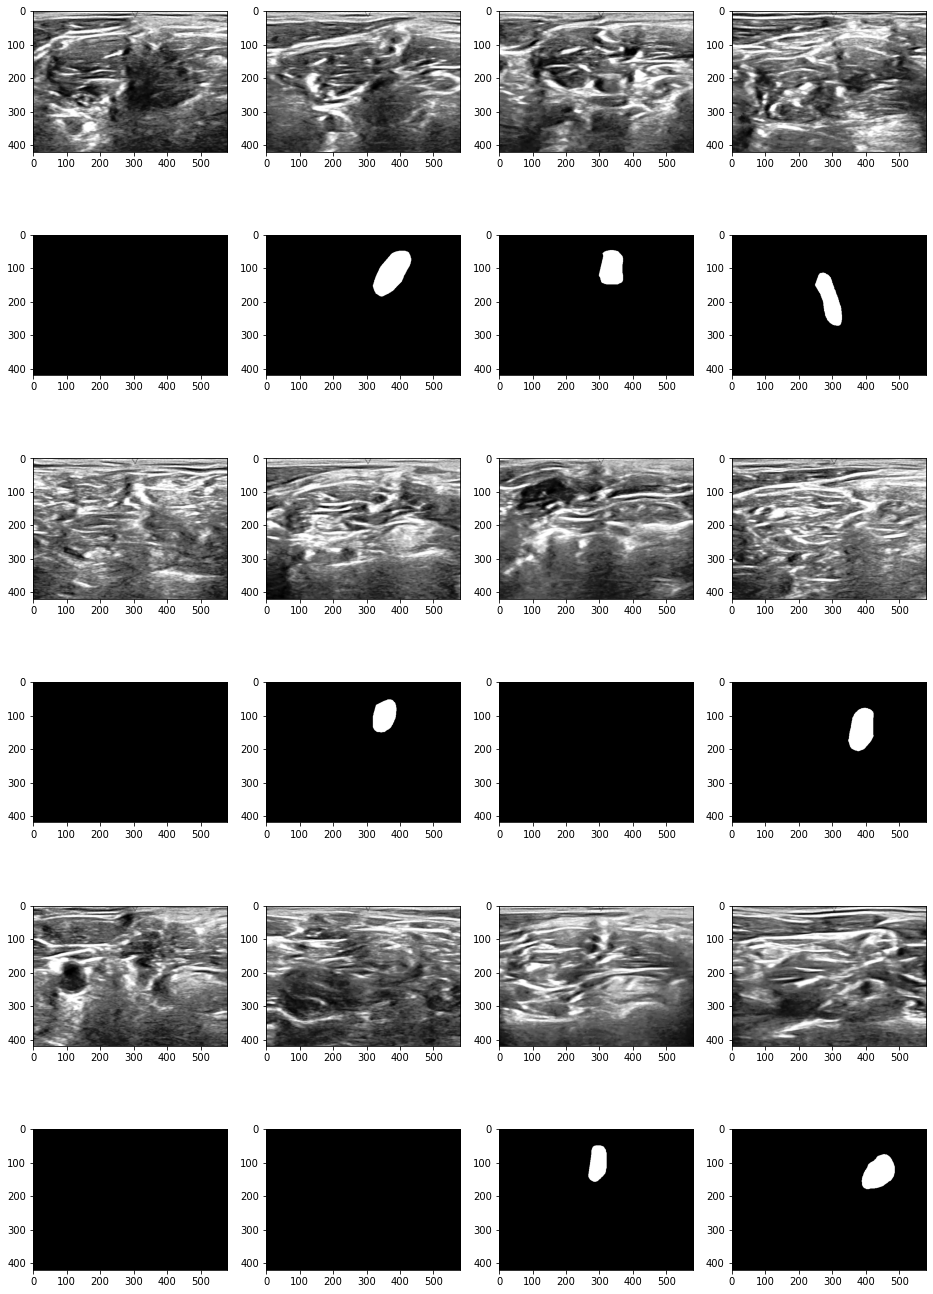

In [37]:
random.seed(3)

rand_pairs = random.sample(all_sub_img_pairs, 12)

_, subaxes = plt.subplots(6, 4, figsize=(16, 24))
subaxes = subaxes.flatten()
for i, (sub_idx, img_idx) in enumerate(rand_pairs):
    subaxes[8*(i // 4) + i%4].imshow(load_image(sub_idx, img_idx), cmap='Greys_r')
    subaxes[8*(i // 4) + 4 + i%4].imshow(load_mask(sub_idx, img_idx), cmap='Greys_r')

In [40]:
# Split train and validation set
# Create X_train, X_val, Y_train, and Y_val

# Given any set of y_pred and y_true, we need to
#   - Compute the IoU
#   - Compute the Dice coefficient
#   - Show N random images at the Pth percentile or below

img = load_image(1, 3)
img.shape

(420, 580)

In [26]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/ --port=8008

Reusing TensorBoard on port 8008 (pid 1319), started 2:25:51 ago. (Use '!kill 1319' to kill it.)